In [1]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from skimage import io, transform

# display images
from torchvision import utils
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

In [2]:
import pandas as pd
path2csv = './database/metadata.csv'
df = pd.read_csv(path2csv)
dir_list = []
for i in range(len(df)):
    dir_list.append('./'+df['directory'][i])
df.drop(['name','index'], axis=1, inplace=True)
#df.drop(['a','v'], axis=1, inplace=True)
df.tail(3)

,directory,heat,weight,colorfulness,saturation,brightness,pleasure,dominance,horizontal_intensity,vertical_intensity,...,waveletAV,waveletAD,waveletBH,waveletBV,waveletBD,vertical_similarity,horizontal_similarity,ruleOfThirds,a,v
45,database/painting/46.jpg,-0.656439,-0.441647,40.601753,0.551661,0.590432,0.528764,-0.272197,2.942104,0.094252,...,0.008289,0.004254,-0.036598,0.006718,-0.003825,0.989790,0.974369,0.975679,7.313833,6.739500
46,database/painting/47.jpg,-1.514192,0.417460,37.687744,0.612761,0.476112,0.463324,-0.165761,0.033158,0.000000,...,0.039468,0.005507,-0.354794,0.039663,-0.004909,0.990409,0.949757,0.947263,6.777833,5.505333
47,database/painting/48.jpg,-0.015000,0.291200,19.397039,0.332638,0.621915,0.502302,-0.366211,0.633664,0.000000,...,-0.007153,0.005683,-0.012274,-0.008732,-0.006829,0.993270,0.979781,0.965576,4.141667,7.076500


In [3]:
from PIL import Image
import torch
from torch.utils.data import Dataset

# fix torch random seed
torch.manual_seed(0)

In [5]:
from PIL import Image

class paintingDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        
        self.metadata = dataframe
        self.root_dir = './database/painting'
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = './' + self.metadata.iloc[idx, 0]
        image = Image.open(img_name)
        feature = self.metadata.iloc[idx,1:]
        feature = np.array([feature])
        feature = feature.astype('float').reshape(-1)
        
        #sample = {'image': image, 'feature': feature}
        
        if self.transform is not None:
            image = self.transform(image)

        return image, feature

In [6]:
train_dataset = paintingDataset(df[:30],transform=transforms.Compose([
                                               transforms.Resize(256),
                                               transforms.RandomCrop(224),
                                               transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                           ]))

test_dataset = paintingDataset(df[30:],transform=transforms.Compose([
                                               transforms.Resize(256),
                                               transforms.RandomCrop(224),
                                               transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                           ]))

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=4, 
                                             shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=4, 
                                             shuffle=False)

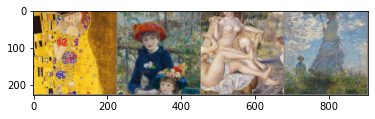

torch.Size([24])


In [8]:
def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, features = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(features[0].size())

In [12]:
from model.resnet import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet50().to(device)

num_epochs = 500
loss_func = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=0.001)

In [54]:
for epoch in range(num_epochs):
    running_loss = 0.0
    
    for data in train_loader:
        inputs, gt = data[0].to(device), data[1].to(device)
        
        opt.zero_grad()
        feature, av = model(inputs)
        
        loss1 = loss_func(feature, gt[:,:22].float())
        loss2 = loss_func(av, gt[:,22:].float())
        loss = loss1 * 0.3 + loss2 * 0.7
        loss.backward()
        
        opt.step()

        running_loss += loss1.item()

    cost = running_loss / len(train_loader)
    if epoch % 10 == 0 :
        print('epoch %d, feature loss: %.3f, av loss: %.4f' %(epoch, cost, loss2))
        testing(model)

epoch 0, feature loss: 7.648, av loss: 1.9981
[[-1.3536029e+00  1.3592179e+00  4.8587914e+00 -1.4143717e+00
  -1.1084316e+00  1.4885800e+00 -1.1541395e+00  1.4149808e+00
   2.5564265e+00  1.5619569e+00 -1.0614299e+00 -1.5083758e+00
   1.5229677e+00 -1.3765279e+00  1.5755732e+00  1.8822263e+00
   1.0383162e+00  1.5121393e+00 -6.7105675e-01  1.5072505e+00
  -7.2654307e-02  1.2877491e+00]
 [-8.1699318e-01  7.8734803e-01  8.6088314e+00 -6.0265493e-01
  -6.9371819e-01  8.1460977e-01 -4.9812829e-01  6.6750413e-01
   7.9977423e-01  9.7347140e-01 -7.2926921e-01 -8.1604475e-01
   8.0358744e-01 -5.6812602e-01  8.3521885e-01  1.0250212e+00
   5.2219033e-01  8.4879184e-01 -3.8535583e-01  7.9778451e-01
  -1.9250917e-01  6.8506539e-01]
 [-8.4492290e-01  4.4742355e-01  1.4916182e+01 -3.3928028e-01
  -4.0349191e-01  7.5319958e-01 -6.7093337e-01  8.4358937e-01
   1.0354509e+00  8.2602292e-01 -6.1188078e-01 -4.5653531e-01
   3.2912639e-01 -5.1918763e-01  4.7634000e-01  2.5189635e-01
   5.2865630e-01  5.

KeyboardInterrupt: 

In [52]:
from sklearn.metrics import mean_squared_error

def testing(model):
    
    with torch.no_grad():
        for data in test_loader:
            inputs, gt = data[0].to(device), data[1].to(device)
            # 신경망에 이미지를 통과시켜 출력을 계산합니다
            feature, av = model(inputs)
            print(feature.cpu().numpy() - gt[:,:22].cpu().float().numpy())
            print(av.cpu().numpy() - gt[:,22:].cpu().float().numpy())